# Similarity analysis with raw sentence embeddings 

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
os.chdir('/home/szhifan/asap-rubric')



/home/szhifan/miniconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/szhifan/miniconda3/envs/work/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [ ]:
path_train = "data/train.tsv"
path_test = "data/public_leaderboard.tsv"
path_test_score = "data/public_leaderboard_solution.csv"
train_df = pd.read_csv(path_train, sep="\t")
train_df = train_df.rename(columns={"Score1": "score"})
train_df = train_df.drop(columns=["Score2"])

test_df = pd.read_csv(path_test, sep="\t")
test_score_df = pd.read_csv(path_test_score)
test_df = pd.concat([test_df, test_score_df], axis=1)
test_df = test_df.drop(columns=["id", "essay_set", "Usage"])
test_df = test_df.rename(columns={"essay_score": "score"}) 
print(test_df.columns) 
print(train_df.columns)

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# # question set 1 
# test_df = test_df[test_df["EssaySet"] == 1]
# initialize the sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the essays for set 1
# embeddings = model.encode(
#     test_df["EssayText"].tolist(),
#     show_progress_bar=True
# )
# # turn embeddings into a DataFrame aligned with scores
# emb_df = pd.DataFrame(embeddings, index=test_df.index)
# emb_df['score'] = test_df['score'].values

# # compute the mean embedding vector for each score value
# mean_emb = emb_df.groupby('score').mean()

# # compute pairwise cosine‐similarity between those mean vectors
# sim_matrix = pd.DataFrame(
#     cosine_similarity(mean_emb.values),
#     index=mean_emb.index,
#     columns=mean_emb.index
# )

# print("Cosine similarity between score groups:")
# print(sim_matrix)



# Similarity analysis with trained bert 

In [ ]:
# prepare dataset and model
from data
from transformers import BertTokenizer, BertForSequenceClassification
import torch
DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
asap = Asap_Dataset() 
asap.merge_scores()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = 2 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

In [18]:
# build optimizer and scheduler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
def build_optimizer(model, args,total_steps):
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and "classifier" not in n
            ],
            "weight_decay": args.weight_decay,
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and "classifier" not in n],
            "weight_decay": 0.0,
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model. named_parameters() if "classifier" in n],
            "weight_decay": args.weight_decay,
            "lr": args.lr2,
        },
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args.warmup_proportion * total_steps,
        num_training_steps=total_steps,
    )
    # if checkpoint path is provided, load optimizer and scheduler states
    if args.checkpoint is not None:
        checkpoint_path = os.path.join(args.checkpoint, "checkpoint")
        if os.path.exists(checkpoint_path):
            optimizer_path = os.path.join(checkpoint_path, "optimizer.pt")
            scheduler_path = os.path.join(checkpoint_path, "scheduler.pt")
            if os.path.isfile(optimizer_path) and os.path.isfile(scheduler_path):
                map_location = DEFAULT_DEVICE
                optimizer.load_state_dict(torch.load(optimizer_path, map_location=map_location))
                scheduler.load_state_dict(torch.load(scheduler_path, map_location=map_location))
                print("Loaded optimizer and scheduler from checkpoint.")

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.save_dir, "checkpoint/optimizer.pt")) and os.path.isfile(
        os.path.join(args.save_dir, "checkpoint/scheduler.pt")
    ):
        map_location = DEFAULT_DEVICE
        optimizer_path = os.path.join(args.save_dir, "checkpoint/optimizer.pt")
        scheduler_path = os.path.join(args.save_dir, "checkpoint/scheduler.pt")
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(optimizer_path, map_location=map_location))
        scheduler.load_state_dict(torch.load(scheduler_path, map_location=map_location))
        print("Loaded the saved scheduler and optimizer.")
    return optimizer, scheduler 

# Explore model output
1. Check if the model assign similar scores to adjacent rubrics
2. Check if the model's first two predictions can cover the correct rubrics 
3. Check what the model's logits value (confidence score) is 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json 
import os
from src.data_prep_alice import AliceRubricPointer
os.chdir('/home/szhifan/asap-rubric')
from src.utils import transform_for_inference, metrics_calc

path = "results/mbert/test_ua_raw_predictions.csv"
df = pd.read_csv(path)
df['logits'] = df['logits'].apply(lambda x: eval(x) if isinstance(x, str) else x)
def check_prediction_order(pred_df):
    
    pred_df["logit_label"] = pred_df['logits'].apply(lambda x: float(x[1])) if len(pred_df['logits'].iloc[0]) > 1 else pred_df['logits']
    grouped = pred_df.groupby('id')
    res = []
    for group_id, group_df in grouped:
        sorted_group = group_df.sort_values('logit_label', ascending=False)
        # Check if the first two rubric levels are consecutive
        if abs(sorted_group['rubric_level'].iloc[0] - sorted_group['rubric_level'].iloc[1]) == 1: 
            res.append(1)
        else:
            res.append(0)
  
    return np.mean(res)
def sample_two_predictions(pred_df):
    pred_df['logits'] = pred_df['logits'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    pred_df["logit_label"] = pred_df['logits'].apply(lambda x: float(x[1])) if len(pred_df['logits'].iloc[0]) > 1 else pred_df['logits']
    grouped = pred_df.groupby('id')
    res = []
    for group_id, group_df in grouped:
        sorted_group = group_df.sort_values('logit_label', ascending=False)
        if sorted_group['level'].iloc[0] in sorted_group['level'].values[:2]:
            res.append(1)
        else:
            res.append(0)
    return np.mean(res)
final_pred = transform_for_inference(df)
metrics_calc(final_pred["pred_id"], final_pred["label_id"])


{'qwk': np.float64(0.8601522271205397)}

Correlation between correctness and confidence: 0.4250


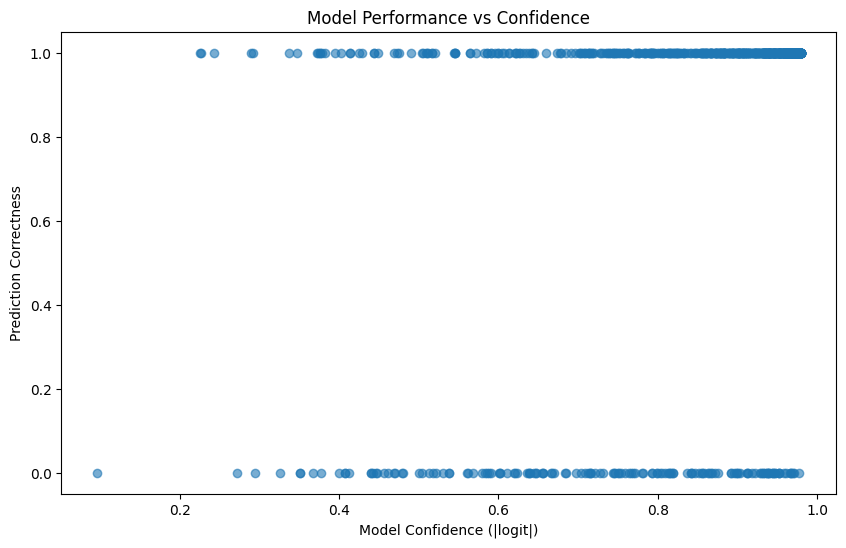

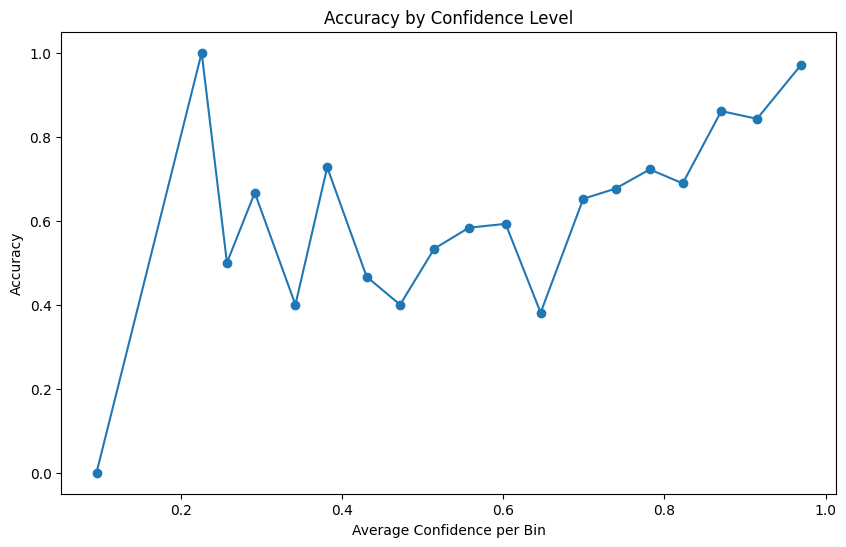


Performance by confidence bins:
    confidence_bin   correct  confidence
0                0  0.000000    0.095479
1                2  1.000000    0.225957
2                3  0.500000    0.257318
3                4  0.666667    0.291854
4                5  0.400000    0.342275
5                6  0.727273    0.381737
6                7  0.466667    0.430642
7                8  0.400000    0.472192
8                9  0.533333    0.514513
9               10  0.583333    0.557489
10              11  0.592593    0.603085
11              12  0.380952    0.646542
12              13  0.652174    0.699407
13              14  0.676471    0.739452
14              15  0.722222    0.781971
15              16  0.688889    0.822826
16              17  0.861111    0.870690
17              18  0.842593    0.914980
18              19  0.971034    0.969644


In [ ]:
# Calculate prediction correctness
final_pred['correct'] = (final_pred['pred_id'] == final_pred['label_id']).astype(int)

# Calculate absolute logit values as confidence measure
import torch

# Calculate absolute logit values as confidence measure

# Apply sigmoid to the confidence score
final_pred['confidence'] = torch.sigmoid(torch.tensor(final_pred['logit_label'].values)).numpy()

# Group by confidence levels and calculate accuracy
confidence_bins = pd.cut(final_pred['confidence'], bins=20, labels=False)

final_pred['confidence_bin'] = confidence_bins

performance_by_confidence = final_pred.groupby('confidence_bin').agg({
    'correct': 'mean',
    'confidence': 'mean'
}).reset_index()

# Calculate correlation
correlation = final_pred['correct'].corr(final_pred['confidence'])
print(f"Correlation between correctness and confidence: {correlation:.4f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(final_pred['confidence'], final_pred['correct'], alpha=0.6)
plt.xlabel('Model Confidence (|logit|)')
plt.ylabel('Prediction Correctness')
plt.title('Model Performance vs Confidence')
plt.show()

# Plot binned performance
plt.figure(figsize=(10, 6))
plt.plot(performance_by_confidence['confidence'], performance_by_confidence['correct'], 'o-')
plt.xlabel('Average Confidence per Bin')
plt.ylabel('Accuracy')
plt.title('Accuracy by Confidence Level')
plt.show()

print("\nPerformance by confidence bins:")
print(performance_by_confidence)